In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tvDatafeed import TvDatafeed,Interval # importing tradingview.com data

tv = TvDatafeed()
ticker = 'NQ1!'

low = 30 # lower bound for RSI strategy
high = 75 # upper bound for RSI strategy

df = tv.get_hist(ticker, 'CME_MINI', interval=Interval.in_15_minute, n_bars=5000).drop(columns = 'symbol')
df.index.names = ['date']

def RSI(data, window=14, adjust=False):
    delta = data.diff(1).dropna()
    loss = delta.copy()
    gains = delta.copy()

    gains[gains<0] = 0
    loss[loss>0] = 0

    gain_ewm = gains.ewm(com=window-1, adjust=adjust).mean()
    loss_ewm = abs(loss.ewm(com=window-1, adjust=adjust).mean())

    RS = gain_ewm / loss_ewm
    RSI = 100 - 100/(1 + RS)
    
    return RSI

df['rsi'] = RSI(df.close, 14)
df = df.dropna()

# Initializing the strategy

s = df.copy()
s['buy'] = np.where(s.rsi < low, 1, 0)
s['sell'] = np.where(s.rsi > high, 1, 0)
buy = s[(s.buy == 1) & (s.buy.shift(1) == 0)]
sell = s[(s.sell == 1) & (s.sell.shift(1) == 0)]
s = pd.concat([buy, sell]).sort_index()
s = s.loc[s.buy != s.buy.shift(1)]
s['profit'] = np.where(s.buy == 1, s.close, np.where(s.sell == 1, s.close, np.nan)) # define the profit of every trade
s.profit = np.where(s.sell == 1, s.close.diff(), np.nan)

you are using nologin method, data you access may be limited


In [2]:
# Profitability s.profit[s.profit>0].sum() / s.profit.abs().sum()
df['buy signals'] = s.buy[s.buy == 1]
df['sell signals'] = s.sell[s.sell == 1]
df['buy signals'] = np.where(df['buy signals'] == 1, df.close, np.nan)
df['sell signals'] = np.where(df['sell signals'] == 1, df.close, np.nan)

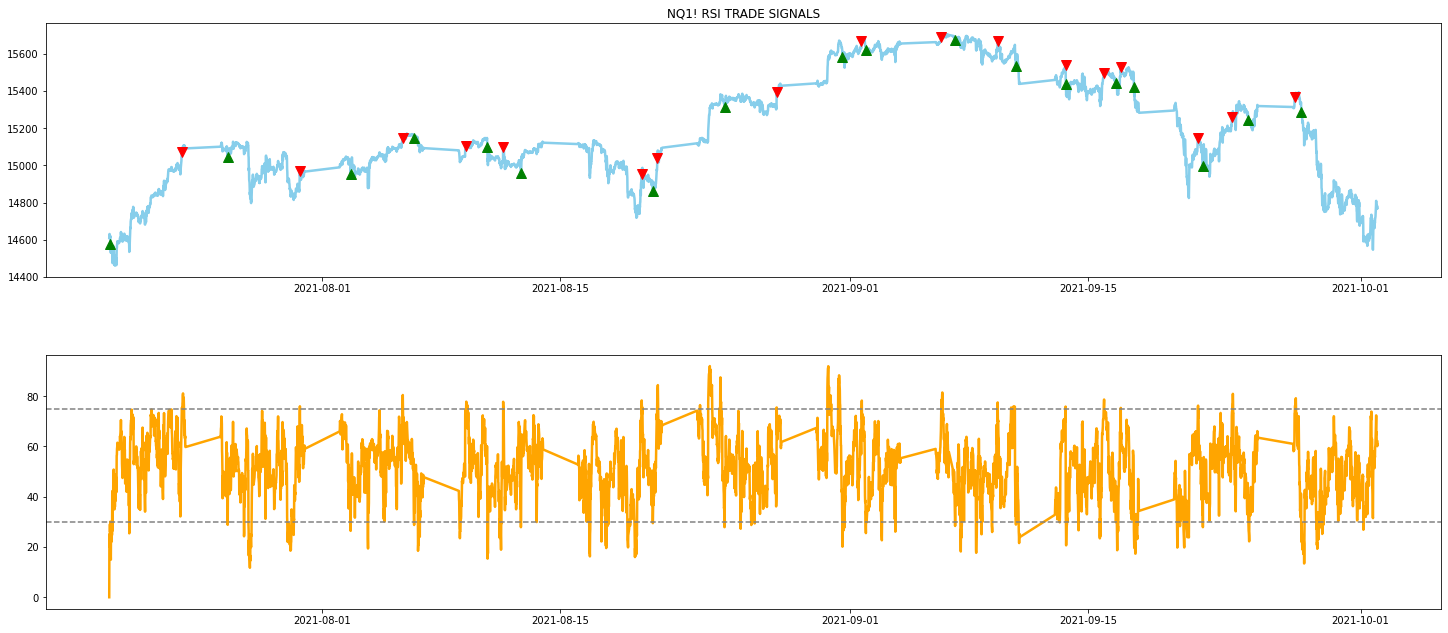

In [3]:
plt.figure(figsize=(25,12))
ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)
ax1.plot(df['close'], linewidth = 2.5, color = 'skyblue', label = f'{ticker}')
ax1.plot(df.index, df['buy signals'], marker = '^', markersize = 10, color = 'green', label = 'BUY SIGNAL')
ax1.plot(df.index, df['sell signals'], marker = 'v', markersize = 10, color = 'red', label = 'SELL SIGNAL')
ax1.set_title(f'{ticker} RSI TRADE SIGNALS')
ax2.plot(df['rsi'], color = 'orange', linewidth = 2.5)
ax2.axhline(low, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.axhline(high, linestyle = '--', linewidth = 1.5, color = 'grey')
plt.show()

In [4]:
# tick = .25 of nq point = 5$
# point = 1 and 20$
tick_price = 5 
coef = .25
profit = ((s.profit/coef)*tick_price).dropna()
print('All the profit for every trade ($): \n', profit)

All the profit for every trade ($): 
 date
2021-07-23 18:45:00    9815.0
2021-07-30 17:00:00   -1525.0
2021-08-05 17:45:00    3820.0
2021-08-09 11:30:00    -850.0
2021-08-11 15:30:00      35.0
2021-08-19 18:30:00    -115.0
2021-08-20 16:45:00    3565.0
2021-08-27 17:00:00    1585.0
2021-09-01 16:30:00    1760.0
2021-09-06 09:15:00    1345.0
2021-09-09 16:30:00     -60.0
2021-09-13 16:15:00      75.0
2021-09-15 22:00:00    1120.0
2021-09-16 22:00:00    1735.0
2021-09-21 10:45:00   -5500.0
2021-09-23 11:15:00    5280.0
2021-09-27 03:45:00    2475.0
Name: profit, dtype: float64


In [5]:
print('Number of trades:', df['buy signals'].count())

return_of_strategy = (s.profit.sum()/s.close.iloc[0]).round(4)
print(f'Return of the strategy: {return_of_strategy*100}%')

return_of_bh = (df.close.iloc[-1]/df.close.iloc[0]-1).round(4)
print(f'Return of the BH strategy: {return_of_bh*100}%')

Number of trades: 18
Return of the strategy: 8.42%
Return of the BH strategy: 1.15%
